# ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 40000 observations in the training set and 10000 in the test set.

The objective is to build various classification models, tune them and find the best one that will help identify failures so that the generator could be repaired before failing/breaking and the overall maintenance cost of the generators can be brought down.

“1” in the target variables should be considered as “failure” and “0” will represent “No failure”.

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a wind turbine where there is no detection by model.
- False positives (FP) are detections in a wind turbine where there is no failure.

So, the maintenance cost associated with the model would be:

**Maintenance cost** = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
where,

- `Replacement cost = $40,000`
- `Repair cost = $15,000`
- `Inspection cost = $5,000`

Here the objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost.

- The minimum possible maintenance cost  =  `Actual failures*(Repair cost) = (TP + FN)*(Repair cost)`
- The maintenance cost associated with model = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`

So, we will try to maximize the ratio of minimum possible maintenance cost and the maintenance cost associated with the model.

The value of this ratio will lie between 0 and 1, the ratio will be 1 only when the maintenance cost associated with the model will be equal to the minimum possible maintenance cost.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# !pip install nb-black

In [2]:
# !pip install imblearn

In [33]:
# !pip install --upgrade scikit-learn
# pip install scikit-learn


In [94]:
import warnings

warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

# Libraries for reading and manipulating data
import pandas as pd
import numpy as np

# Library for splitting data
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


# Libaries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set limits on number of displayed columns and rows
pd.set_option("display.max_columns", None)  # no maximum limit
pd.set_option("display.max_rows", 200)  # maximum of 200 rows

# Library for building and showing decision tree models
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Library for Bagging ensemble technique
from sklearn.ensemble import BaggingClassifier

# Library for Random Forest ensemble technique
from sklearn.ensemble import RandomForestClassifier

# Library for AdaBoost ensemble technique
from sklearn.ensemble import AdaBoostClassifier

# Library for Gradient Boosting ensemble technique
from sklearn.ensemble import GradientBoostingClassifier

# Library for XGBoost ensemble technique
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


# Library for Stacking ensemble technique
from sklearn.ensemble import StackingClassifier

# To tune different models
from sklearn.model_selection import GridSearchCV

# Libraries for calculating different metric scores
from sklearn.metrics import (f1_score, accuracy_score, recall_score, precision_score, make_scorer, confusion_matrix)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline


## Loading Data

In [10]:
# Loading the dataset
train = pd.read_csv("/content/drive/MyDrive/Model_Tuning/Train.csv.csv")

In [11]:
# Checking the number of rows and columns in the data
train.shape

(20000, 41)

- There are 20,000 rows and 41 attributes (including the predictor) in the dataset

## Data Overview

In [12]:
data = train.copy()

In [13]:
# let's view the first 5 rows of the data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.464606,-4.679129,3.101546,0.506130,-0.221083,-2.032511,-2.910870,0.050714,-1.522351,3.761892,...,3.059700,-1.690440,2.846296,2.235198,6.667486,0.443809,-2.369169,2.950578,-3.480324,0
1,3.365912,3.653381,0.909671,-1.367528,0.332016,2.358938,0.732600,-4.332135,0.565695,-0.101080,...,-1.795474,3.032780,-2.467514,1.894599,-2.297780,-1.731048,5.908837,-0.386345,0.616242,0
2,-3.831843,-5.824444,0.634031,-2.418815,-1.773827,1.016824,-2.098941,-3.173204,-2.081860,5.392621,...,-0.257101,0.803550,4.086219,2.292138,5.360850,0.351993,2.940021,3.839160,-4.309402,0
3,1.618098,1.888342,7.046143,-1.147285,0.083080,-1.529780,0.207309,-2.493629,0.344926,2.118578,...,-3.584425,-2.577474,1.363769,0.622714,5.550100,-1.526796,0.138853,3.101430,-1.277378,0
4,-0.111440,3.872488,-3.758361,-2.982897,3.792714,0.544960,0.205433,4.848994,-1.854920,-6.220023,...,8.265896,6.629213,-10.068689,1.222987,-3.229763,1.686909,-2.163896,-3.644622,6.510338,0


In [14]:
# let's view the last 5 rows of the data
data.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071318,-1.088279,-0.796174,-3.011720,-2.287540,2.807310,0.481428,0.105171,-0.586599,-2.899398,...,-8.273996,5.745013,0.589014,-0.649988,-3.043174,2.216461,0.608723,0.178193,2.927755,1
19996,2.890264,2.483069,5.643919,0.937053,-1.380870,0.412051,-1.593386,-5.762498,2.150096,0.272302,...,-4.159092,1.181466,-0.742412,5.368979,-0.693028,-1.668971,3.659954,0.819863,-1.987265,0
19997,-3.896979,-3.942407,-0.351364,-2.417462,1.107546,-1.527623,-3.519882,2.054792,-0.233996,-0.357687,...,7.112162,1.476080,-3.953710,1.855555,5.029209,2.082588,-6.409304,1.477138,-0.874148,0
19998,-3.187322,-10.051662,5.695955,-4.370053,-5.354758,-1.873044,-3.947210,0.679420,-2.389254,5.456756,...,0.402812,3.163661,3.752095,8.529894,8.450626,0.203958,-7.129918,4.249394,-6.112267,0
19999,-2.686903,1.961187,6.137088,2.600133,2.657241,-4.290882,-2.344267,0.974004,-1.027462,0.497421,...,6.620811,-1.988786,-1.348901,3.951801,5.449706,-0.455411,-2.202056,1.678229,-1.974413,0


- The attributes are ciphered

In [15]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

 - All of the values are numerical
 - Predictors V1 and V2 each have 18 missing values
 - All of the feature columns are float data types and the target is an integer.

In [19]:
# let's check for duplicate values in the data
data.duplicated().sum()

0

- There are no duplicate values in the dataset

In [20]:
# let's check for number of unique values in each column
data.nunique()

V1        19982
V2        19982
V3        20000
V4        20000
V5        20000
V6        20000
V7        20000
V8        20000
V9        20000
V10       20000
V11       20000
V12       20000
V13       20000
V14       20000
V15       20000
V16       20000
V17       20000
V18       20000
V19       20000
V20       20000
V21       20000
V22       20000
V23       20000
V24       20000
V25       20000
V26       20000
V27       20000
V28       20000
V29       20000
V30       20000
V31       20000
V32       20000
V33       20000
V34       20000
V35       20000
V36       20000
V37       20000
V38       20000
V39       20000
V40       20000
Target        2
dtype: int64

- All attributes except "Target" have all unique values

In [35]:
# let's view the statistical summary of the numerical columns in the data
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000000,19982.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-0.271996,0.440430,2.484699,-0.083152,-0.053752,-0.995443,-0.879325,-0.548195,-0.016808,-0.012998,-1.895393,1.604825,1.580486,-0.950632,-2.414993,-2.925225,-0.134261,1.189347,1.181808,0.023608,-3.611252,0.951835,-0.366116,1.134389,-0.002186,1.873785,-0.612413,-0.883218,-0.985625,-0.015534,0.486842,0.303799,0.049825,-0.462702,2.229620,1.514809,0.011316,-0.344025,0.890653,-0.875630,0.055500
std,3.441625,3.150784,3.388963,3.431595,2.104801,2.040970,1.761626,3.295756,2.160568,2.193201,3.124322,2.930454,2.874658,1.789651,3.354974,4.221717,3.345462,2.592276,3.396925,3.669477,3.567690,1.651547,4.031860,3.912069,2.016740,3.435137,4.368847,1.917713,2.684365,3.005258,3.461384,5.500400,3.575285,3.183841,2.937102,3.800860,1.788165,3.948147,1.753054,3.012155,0.228959
min,-11.876451,-12.319951,-10.708139,-15.082052,-8.603361,-10.227147,-7.949681,-15.657561,-8.596313,-9.853957,-14.832058,-12.948007,-13.228247,-7.738593,-16.416606,-20.374158,-14.091184,-11.643994,-13.491784,-13.922659,-17.956231,-10.122095,-14.866128,-16.387147,-8.228266,-11.834271,-14.904939,-9.269489,-12.579469,-14.796047,-13.722760,-19.876502,-16.898353,-17.985094,-15.349803,-14.833178,-5.478350,-17.375002,-6.438880,-11.023935,0.000000
25%,-2.737146,-1.640674,0.206860,-2.347660,-1.535607,-2.347238,-2.030926,-2.642665,-1.494973,-1.411212,-3.922404,-0.396514,-0.223545,-2.170741,-4.415322,-5.634240,-2.215611,-0.403917,-1.050168,-2.432953,-5.930360,-0.118127,-3.098756,-1.468062,-1.365178,-0.337863,-3.652323,-2.171218,-2.787443,-1.867114,-1.817772,-3.420469,-2.242857,-2.136984,0.336191,-0.943809,-1.255819,-2.987638,-0.272250,-2.940193,0.000000
50%,-0.747917,0.471536,2.255786,-0.135241,-0.101952,-1.000515,-0.917179,-0.389085,-0.067597,0.100973,-1.921237,1.507841,1.637185,-0.957163,-2.382617,-2.682705,-0.014580,0.883398,1.279061,0.033415,-3.532888,0.974687,-0.262093,0.969048,0.025050,1.950531,-0.884894,-0.891073,-1.176181,0.184346,0.490304,0.052073,-0.066249,-0.255008,2.098633,1.566526,-0.128435,-0.316849,0.919261,-0.920806,0.000000
75%,1.840112,2.543967,4.566165,2.130615,1.340480,0.380330,0.223695,1.722965,1.409203,1.477045,0.118906,3.571454,3.459886,0.270677,-0.359052,-0.095046,2.068751,2.571770,3.493299,2.512372,-1.265884,2.025594,2.451750,3.545975,1.397112,4.130037,2.189177,0.375884,0.629773,2.036229,2.730688,3.761722,2.255134,1.436935,4.064358,3.983939,1.175533,2.279399,2.057540,1.119897,0.000000
max,15.493002,13.089269,17.090919,13.236381,8.133797,6.975847,8.006091,11.679495,8.137580,8.108472,11.826433,15.080698,15.419616,5.670664,12.246455,13.583212,16.756432,13.179863,13.237742,16.052339,13.840473,7.409856,14.458734,17.163291,8.223389,16.836410,17.560404,6.527643,10.722055,12.505812,17.255090,23.633187,16.692486,14.358213,15.291065,19.329576,7.467006,15.289923,7.759877,10.654265,1.000000


 - The target values are either 0 or 1
 - The range of values for all of the features are from ~-21 to ~24
 - Predictor V3 has the highest mean of all predictors with a value of 2.485
 - Predictor V21 has the lowest mean of all predictors with a value of -3.611



## Univariate Analysis

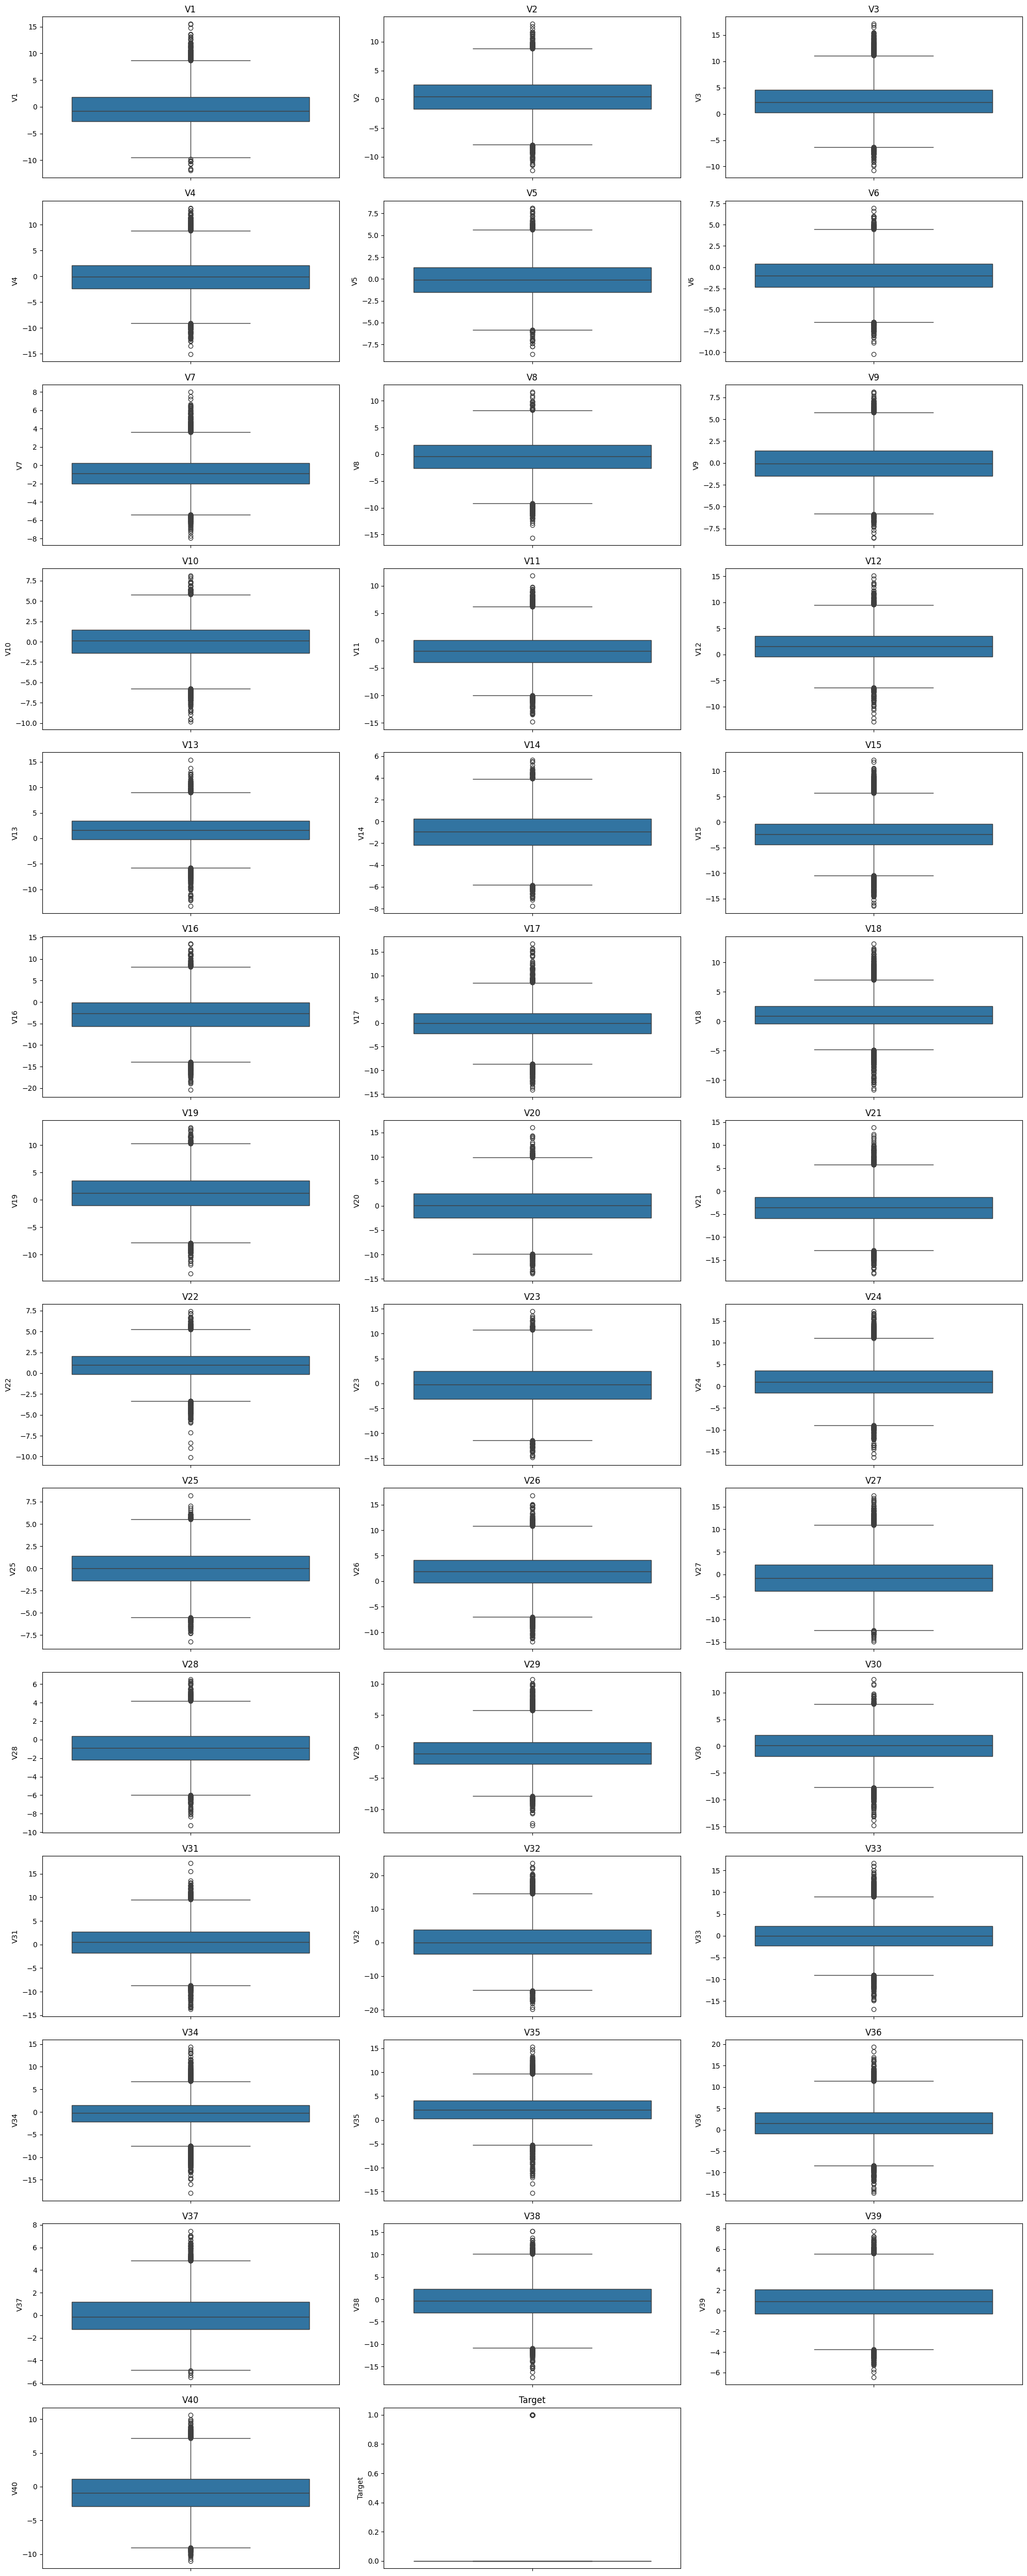

In [21]:
cols = data.columns.tolist()

plt.figure(figsize=(20, 50))
for i, variable in enumerate(cols):
    plt.subplot(14, 3, i + 1)
    sns.boxplot(data[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

- There are positive and negative outliers for all attributes "V1" to "V40". The scale of attributes are more or less the same (somewhere between -20 to +20). Since not much is known about the attributes, the outliers will not be treated and are assumed to be real data trends

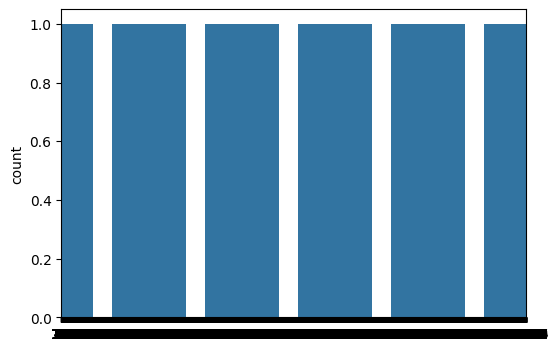

0    18890
1     1110
Name: Target, dtype: int64

In [36]:
plt.figure(figsize=(6, 4))
sns.countplot(data["Target"])
plt.show()
data["Target"].value_counts()

- "Target" class is imbalanced with 37813 or 94.53% "No failures (i.e., 0)" and 2187 or 5.47% "Failures (i.e., 1)"

## Data Pre-processing

In [37]:
# Split data
df = data.copy()

X = df.drop(["Target"], axis=1)
y = df["Target"]

In [38]:
# Splitting data into training and validation sets:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)
print(X_train.shape, X_val.shape)

(14000, 40) (6000, 40)


- There are 14000 rows in the training and 6000 rows in the validation sets

In [39]:
y_train.value_counts()

0    13223
1      777
Name: Target, dtype: int64

In [40]:
y_val.value_counts()

0    5667
1     333
Name: Target, dtype: int64

- Stratify has maintained a distribution of 94.45% "No failures" or "0" and 5.55% "Failures" or "1" in both the test and validation splits

### Missing-Value Treatment

* We will use median to impute missing values in "V1" and "V2" columns.

In [41]:
imputer = SimpleImputer(strategy="median")
impute = imputer.fit(X_train)

X_train = impute.transform(X_train)
X_val = imputer.transform(X_val)

## Model evaluation criterion

### 3 types of cost are associated with the provided problem
1. Replacement cost - False Negatives - Predicting no failure, while there will be a failure
2. Inspection cost - False Positives - Predicting failure, while there is no failure
3. Repair cost - True Positives - Predicting failure correctly

### How to reduce the overall cost?
* We need to create a customized metric, that can help to bring down the overall cost
* The cost associated with any model = (TPX15000) + (FPX5000) + (FNX40000)
* And the minimum possible cost will be when, the model will be able to identify all failures, in that case, the cost will be (TP + FN)X15000
* So, we will try to maximize `Minimum cost/Cost associated with model`

### Let's create two functions to calculate different metrics and confusion matrix

In [42]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
    Cost = TP * 15 + FP * 5 + FN * 40  # maintenance cost by using model
    Min_Cost = (
        TP + FN
    ) * 15  # minimum possible maintenance cost = number of actual positives
    Percent = (
        Min_Cost / Cost
    )  # ratio of minimum possible maintenance cost and maintenance cost by model

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "Minimum_Vs_Model_cost": Percent,
        },
        index=[0],
    )

    return df_perf

In [43]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

###  Defining scorer to be used for hyperparameter tuning

- Every prediction of a classification model will be either a TP, FP, FN or TN
- For this classification problem, we need to reduce the maintenance cost, which can be reiterated as:
  - Maximize (minimum possible maintenance cost/maintenance cost)

In [44]:
# defining metric to be used for optimization and with cross-validation
def Minimum_Vs_Model_cost(y_train, y_pred):
    """
    We want the model to optimize the maintenance cost and reduce it to the lowest possible value.
    The lowest possible maintenance cost will be achieved when each sample is predicted correctly.

    In such a scenario, the maintenance cost will be the total number of failures times the maintenance cost of replacing one generator,
    which is given by (TP + FN) * 40 (i.e., the actual positives*40).
    For any other scenario,
    the maintenance cost associated with the model will be given by (TP * 15 + FP * 5 + FN * 40).

    We will use the ratio of these two maintenance costs as the cost function for our model.
    The greater the ratio, the lower the associated maintenance cost and the better the model.
    """
    TP = confusion_matrix(y_train, y_pred)[1, 1]
    FP = confusion_matrix(y_train, y_pred)[0, 1]
    FN = confusion_matrix(y_train, y_pred)[1, 0]
    return ((TP + FN) * 15) / (TP * 15 + FP * 5 + FN * 40)


# A value of .80 here, will represent that the minimum maintenance cost is 80% of the maintenance cost associated with the model.
# Since minimum maintenance cost is constant for any data, when minimum cost will become 100% of maintenance cost associated with the model
# Model will have give the least possible maintenance cost.


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Higher the values, the lower the maintenance cost

## Model Building with Original Training data

In [45]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

Logistic Regression: 0.5316984986583597
dtree: 0.6272059730009276
Random forest: 0.6807632984487395
Bagging: 0.6660391614500791
Adaboost: 0.6154174313620364
GBM: 0.6761183106181037
Xgboost: 0.7553044799087896


In [46]:
print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = Minimum_Vs_Model_cost(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 0.5320703035836567
dtree: 1.0
Random forest: 0.9978595890410958
Bagging: 0.9301675977653632
Adaboost: 0.6341131664853101
GBM: 0.76905311778291
Xgboost: 1.0


In [47]:
print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = Minimum_Vs_Model_cost(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

Logistic Regression: 0.5370967741935484
dtree: 0.624375
Random forest: 0.6927877947295423
Bagging: 0.6809815950920245
Adaboost: 0.6166666666666667
GBM: 0.6837782340862423
Xgboost: 0.7726218097447796


- The cross validation training performance scores (customized metric) are similar to the validation performance score. This indicates that the default algorithms on original dataset are able to generalize well
- There is a tendency for some models (decision tree, random forest, bagging and XGBoost) to overfit the training set; as the training performance score (customized metric) approaches 1

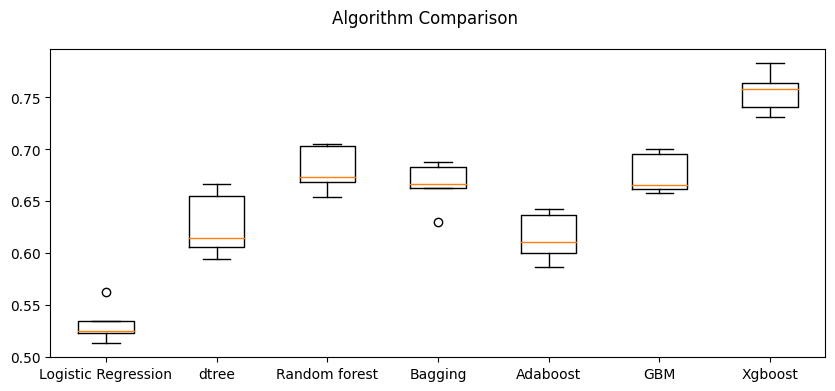

In [48]:
# Plotting boxplots for CV scores of all models defined above

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- XGBoost (~ 0.77) and Random Forest (~ 0.71) have the best average (& median) training cross validation scores (on the customized metric). This is closely followed by Bagging Classifier (~ 0.68)
- XGBoost and AdaBoost each have one outlier as can be observed from the boxplot
- The boxplot widths (spread of CV scores) is small for XGBoost, Random Forest and Bagging Classifier as well, indicating these are reliable models to choose for further optimization

## Model Building with Oversampled Training data


In [49]:
print(
    "Before Oversampling, counts of label '1 (Failures)': {}".format(sum(y_train == 1))
)
print(
    "Before Oversampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train == 0)
    )
)

Before Oversampling, counts of label '1 (Failures)': 777
Before Oversampling, counts of label '0 (No failures)': 13223 



In [52]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [ ]:
print(
    "After Oversampling, counts of label '1 (Failures)': {}".format(
        sum(y_train_over == 1)
    )
)
print(
    "After Oversampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train_over == 0)
    )
)

After Oversampling, counts of label '1 (Failures)': 26469
After Oversampling, counts of label '0 (No failures)': 26469 



<IPython.core.display.Javascript object>

- To handle class imbalance in "Target" attribute, synthetic minority oversampling technique was employed to generate synthetic data points for minority class of importance (i.e, class "1" or No failures)
- After applying SMOTE, we have equal number of class "1" and calss "0" target outcomes

In [53]:
models_over = []  # Empty list to store all the models

# Appending models into the list

models_over.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models
score_over = []

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

Logistic Regression: 0.8194163737917792
dtree: 0.9386129564423099
Random forest: 0.9711519462836454
Bagging: 0.9557133408484612
Adaboost: 0.8434780680574487
GBM: 0.8919788115984149
Xgboost: 0.9820121503585153


In [54]:
print("\n" "Training Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = Minimum_Vs_Model_cost(y_train_over, model.predict(X_train_over))
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 0.8194381326172279
dtree: 1.0
Random forest: 1.0
Bagging: 0.9969590349334003
Adaboost: 0.8441649642492339
GBM: 0.8979356240662774
Xgboost: 0.9998739728789635


In [55]:
print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = Minimum_Vs_Model_cost(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

Logistic Regression: 0.5015060240963856
dtree: 0.627906976744186
Random forest: 0.7884767166535123
Bagging: 0.7324046920821115
Adaboost: 0.5855803048065651
GBM: 0.7140814867762688
Xgboost: 0.7847604084838963


- The cross validation training performance scores (customized metric) are much higher than validation perfromance score. This indicates that the default algorithms on oversampled dataset are not able to generalize well
- It is likely that the algorithms are overfitting the noise in the training sets which explains the trends in the observed performance scores (cross validation training scores ~ training score >> validation score). This will be a concern taking these models to production

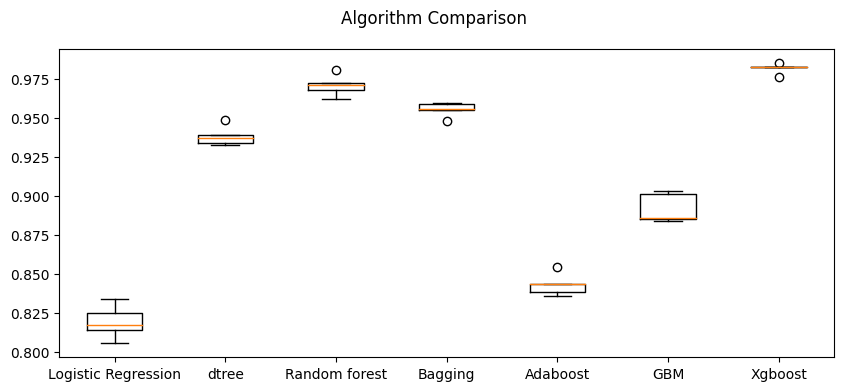

In [56]:
# Plotting boxplots for CV scores of all models defined above

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names)

plt.show()

- The average (& median) training cross validation scores on oversampled dataset has increased to match training performance scores across algorithms. This indicates potential overfitting of noise in the training datasets

## Model Building with Undersampled data

In [59]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [60]:
print(
    "After Undersampling, counts of label '1 (Failures)': {}".format(
        sum(y_train_un == 1)
    )
)
print(
    "After Undersampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train_un == 0)
    )
)

After Undersampling, counts of label '1 (Failures)': 777
After Undersampling, counts of label '0 (No failures)': 777 



- Another technique to handle class imbalance in "Target" attribute is random undersampling, wherein only random samples from the majority class are chosen for model building. While this helps in dealing with models potentially overfitting, it can often lead to poor performing models due to "loss of information" from not considering all datapoints available
- After random undersampling, we again have equal number of class "1" and class "0" (and overall less number of datapoints for model building)

In [61]:
models_un = []  # Empty list to store all the models

# Appending models into the list

models_un.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models_un.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_un.append(("Random forest", RandomForestClassifier(random_state=1)))
models_un.append(("Bagging", BaggingClassifier(random_state=1)))
models_un.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_un.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_un.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_un = []  # Empty list to store all model's CV scores
names_un = []  # Empty list to store name of the models
score_un = []

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models_un:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results_un.append(cv_result)
    names_un.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

Logistic Regression: 0.7976859395663183
dtree: 0.7835207678693784
Random forest: 0.8520819199404063
Bagging: 0.8191168871899597
Adaboost: 0.800669582148162
GBM: 0.8344888877100936
Xgboost: 0.8444224361378929


In [62]:
print("\n" "Training Performance:" "\n")

for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = Minimum_Vs_Model_cost(y_train_un, model.predict(X_train_un))
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 0.7963785445848992
dtree: 1.0
Random forest: 1.0
Bagging: 0.9765395894428153
Adaboost: 0.8538461538461538
GBM: 0.920252664824319
Xgboost: 1.0


In [63]:
print("\n" "Validation Performance:" "\n")

for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = Minimum_Vs_Model_cost(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

Logistic Regression: 0.47684964200477326
dtree: 0.4495949594959496
Random forest: 0.6466019417475728
Bagging: 0.6125076640098099
Adaboost: 0.5128336755646817
GBM: 0.624765478424015
Xgboost: 0.6795918367346939


- The performance score (customized metric) have dropped on the validation undersampled dataset than original dataset. This could be likely that the algorithms are overfitting the noise & underfitting the information in the undersampled datasets. This will again be a concern taking these models to production

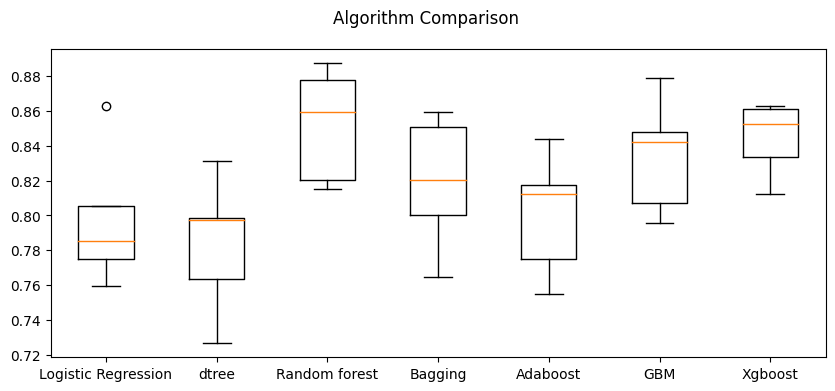

In [64]:
# Plotting boxplots for CV scores of all models defined above

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_un)
ax.set_xticklabels(names)

plt.show()

- The algorithms are able to give better performance on the cross validation training scores on undersampled dataset in comparison to original dataset as can be seen from the boxplots. However, the issue is the lack of generalizatbility in carrying forth the performance to the validation set

## Model Selection

- Models built on original dataset have given generalized performance on cross validation training and validation sets unlike models built on oversampled or undersampled sets
- Mean cross validation scores on training sets are highest with XGBoost, Random Forest & Bagging Classifiers (~77, ~71 and ~68% respectively). These models will be tuned further to try to increase performance

## HyperparameterTuning

In [67]:
# defining model - XGBoost Hyperparameter Tuning
model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": np.arange(150, 300, 50),
    "scale_pos_weight": [5, 10],
    "learning_rate": [0.1, 0.2],
    "gamma": [0, 3, 5],
    "subsample": [0.8, 0.9],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scorer,
    cv=3,
    random_state=1,
    n_jobs=-1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.7917315176741533:


In [68]:
# building model with best parameters
xgb_tuned = XGBClassifier(
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.1,
    gamma=3,
    random_state=1,
    eval_metric="logloss",
)

# Fit the model on training data
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [69]:
# Calculating different metrics on training set
xgboost_random_train = model_performance_classification_sklearn(
    xgb_tuned, X_train, y_train
)
print("Training performance:")
xgboost_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.999071,1.0,0.983544,0.991704,0.994454


In [70]:
# Calculating different metrics on validation set
xgboost_random_val = model_performance_classification_sklearn(xgb_tuned, X_val, y_val)
print("Validation performance:")
xgboost_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.987333,0.840841,0.924092,0.880503,0.776224


- The best hyperparameters using RandomizedSearch CV for XGBoost model were found to be: subsample 0.9, scale_pos_weight 10, n_estimators 250, learning_rate 0.1 and gamma 3
- The average cross validation training performance score (customized metric) using the best parameter XGBoost model is 0.80. This is similar to the performance score (customized metric) on the validation set i.e., 0.82. This indicates the model may generalize with a performance score of ~0.80-0.82
- The model does however have a tendency to overfit the training set as can be observed from training performance (customized metric score of 0.998)

In [71]:
# defining model - Random Forest Hyperparameter Tuning
model2 = RandomForestClassifier(random_state=1, oob_score=True, bootstrap=True)

param_grid2 = {
    "n_estimators": [150, 250],
    "min_samples_leaf": np.arange(1, 3),
    "max_features": ["sqrt", "log2"],
    "max_samples": np.arange(0.2, 0.6, 0.1),
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv2 = RandomizedSearchCV(
    estimator=model2,
    param_distributions=param_grid2,
    n_iter=50,
    scoring=scorer,
    cv=5,
    random_state=1,
    n_jobs=-1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv2.fit(X_train, y_train)
print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv2.best_params_, randomized_cv2.best_score_
    )
)

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.5000000000000001, 'max_features': 'sqrt'} with CV score=0.6557584099550935:


In [72]:
# building model with best parameters
rf_tuned = RandomForestClassifier(
    n_estimators=250,
    min_samples_leaf=1,
    max_samples=0.5000000000000001,
    max_features="sqrt",
    random_state=1,
)

# Fit the model on training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.5000000000000001, n_estimators=250,
                       random_state=1)

In [73]:
# Calculating different metrics on training set
rf_random_train = model_performance_classification_sklearn(rf_tuned, X_train, y_train)
print("Training performance:")
rf_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.992571,0.866152,1.0,0.928276,0.817608


In [74]:
# Calculating different metrics on validation set
rf_random_val = model_performance_classification_sklearn(rf_tuned, X_val, y_val)
print("Validation performance:")
rf_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.983833,0.717718,0.987603,0.831304,0.678668


- The best hyperparameters using RandomizedSearch CV for Random forest model were found to be: n_estimators 250, min_sample_leaf 1, max_features 'sqrt', max_samples 0.5
- The average 5 fold cross validation training performance score (customized metric) using the best parameter Random forest model is 0.692. This is similar to the performance score (customized metric) on the validation set i.e., 0.697. This indicates the model may generalize with a performance score of ~0.69
- The model has a slight tendency (although not as much as XGBoost tuned) to overfit the training set as can be observed from training performance (customized metric score of 0.8336)

In [75]:
# defining model - Bagging Classifier Hyperparameter Tuning
model3 = BaggingClassifier(random_state=1)

param_grid3 = {
    "max_samples": [0.8, 0.9],
    "max_features": [0.8, 0.9],
    "n_estimators": [40, 50],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv3 = RandomizedSearchCV(
    estimator=model3,
    param_distributions=param_grid3,
    n_iter=50,
    scoring=scorer,
    cv=5,
    random_state=1,
    n_jobs=-1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv3.fit(X_train, y_train)
print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv3.best_params_, randomized_cv3.best_score_
    )
)

Best parameters are {'n_estimators': 50, 'max_samples': 0.8, 'max_features': 0.9} with CV score=0.6812367143149652:


In [76]:
# building model with best parameters
bagging_tuned = BaggingClassifier(
    n_estimators=50, max_samples=0.9, max_features=0.8, random_state=1,
)

# Fit the model on training data
bagging_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=50,
                  random_state=1)

In [77]:
# Calculating different metrics on train set
bagging_random_train = model_performance_classification_sklearn(
    bagging_tuned, X_train, y_train
)
print("Training performance:")
bagging_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.999286,0.98713,1.0,0.993523,0.979


In [78]:
# Calculating different metrics on validation set
bagging_random_val = model_performance_classification_sklearn(
    bagging_tuned, X_val, y_val
)
print("Validation performance:")
bagging_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.985333,0.756757,0.972973,0.851351,0.708009


- The best hyperparameters using RandomizedSearch CV for Bagging Classifier were found to be: n_estimator 50, max_samples 0.9, max_features 0.8
- The average 5 fold cross validation training performance score (customized metric) using the best parameter Bagging classifier is 0.71. This is similar to the performance score (customized metric) on the validation set i.e., 0.70. This indicates the model may generalize with a performance score of ~0.69-0.71
- The model does however have a tendency to overfit the training set as can be observed from training performance (customized metric score of 0.982)

## Model Performance comparison and choosing the final model

In [79]:
# training performance comparison

models_train_comp_df = pd.concat(
    [xgboost_random_train.T, rf_random_train.T, bagging_random_train.T,], axis=1,
)
models_train_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "Random forest Tuned with Random search",
    "Bagging Tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,XGBoost Tuned with Random search,Random forest Tuned with Random search,Bagging Tuned with Random Search
Accuracy,0.999071,0.992571,0.999286
Recall,1.000000,0.866152,0.987130
Precision,0.983544,1.000000,1.000000
F1,0.991704,0.928276,0.993523
Minimum_Vs_Model_cost,0.994454,0.817608,0.979000


In [80]:
# training performance comparison

models_val_comp_df = pd.concat(
    [xgboost_random_val.T, rf_random_val.T, bagging_random_val.T,], axis=1,
)
models_val_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "Random forest Tuned with Random search",
    "Bagging Tuned with Random Search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,XGBoost Tuned with Random search,Random forest Tuned with Random search,Bagging Tuned with Random Search
Accuracy,0.987333,0.983833,0.985333
Recall,0.840841,0.717718,0.756757
Precision,0.924092,0.987603,0.972973
F1,0.880503,0.831304,0.851351
Minimum_Vs_Model_cost,0.776224,0.678668,0.708009


- The XGBoost Tuned model with Random Search is giving the highest performance score (Minimum_Vs_Model_cost) of 0.821 on the Validation Set. Although this algorithm is giving much higher performance on training set (0.998) indicating overfitting, we still observe the following -
  - The average cross validation Training performance score (Minimum_Vs_Model_cost) with this model is 0.80, similar to the validation score of 0.821
  - The accuracy, precision and F1 scores of the training & validation models are very much comparable
    
    
- We will choose this tuned model to see if it can generalize well on the testing dataset to give a likewise high performance score (Minimum_Vs_Model_cost) ~ 0.8

## Test set final performance

In [82]:
# Loading the dataset
test = pd.read_csv("/content/drive/MyDrive/Model_Tuning/Test.csv.csv")

In [83]:
X_test = test.drop(["Target"], axis=1)
y_test = test["Target"]

In [84]:
y_test.value_counts()

0    4718
1     282
Name: Target, dtype: int64

- The test data has likewise 94.36% "0" or "No failures" and 5.64% "1" or "Failures"

In [85]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

- There are 11 & 7 missing values for attributes "V1" and "V2"

In [86]:
imputer = SimpleImputer(strategy="median")
impute = imputer.fit(X_test)
X_test = imputer.transform(X_test)

In [87]:
print("\n" "Test Performance:" "\n")

final_model = XGBClassifier(
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.1,
    gamma=3,
    random_state=1,
    eval_metric="logloss",
)
name = "XGboost_tuned"

final_model.fit(X_train, y_train)
final_scores = Minimum_Vs_Model_cost(y_test, final_model.predict(X_test))
print("{}: {}".format(name, final_scores))


Test Performance:

XGboost_tuned: 0.7621621621621621


In [88]:
xgboost_test = model_performance_classification_sklearn(final_model, X_test, y_test)
xgboost_test

,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.9864,0.826241,0.924603,0.872659,0.762162


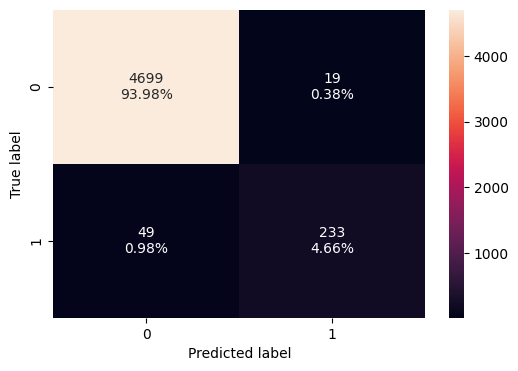

In [89]:
# creating confusion matrix
confusion_matrix_sklearn(final_model, X_test, y_test)

- The XGBoost tuned model is generalizing well on the test data with a Minimum_Vs_Model_cost of 0.792 (the cross validation training average score was 0.799 and the validation score was 0.821)
- The model is able to make predictions resulting in a maintenance cost ~ (1/0.792 or ~1.26) times the minimum maintenance cost possible

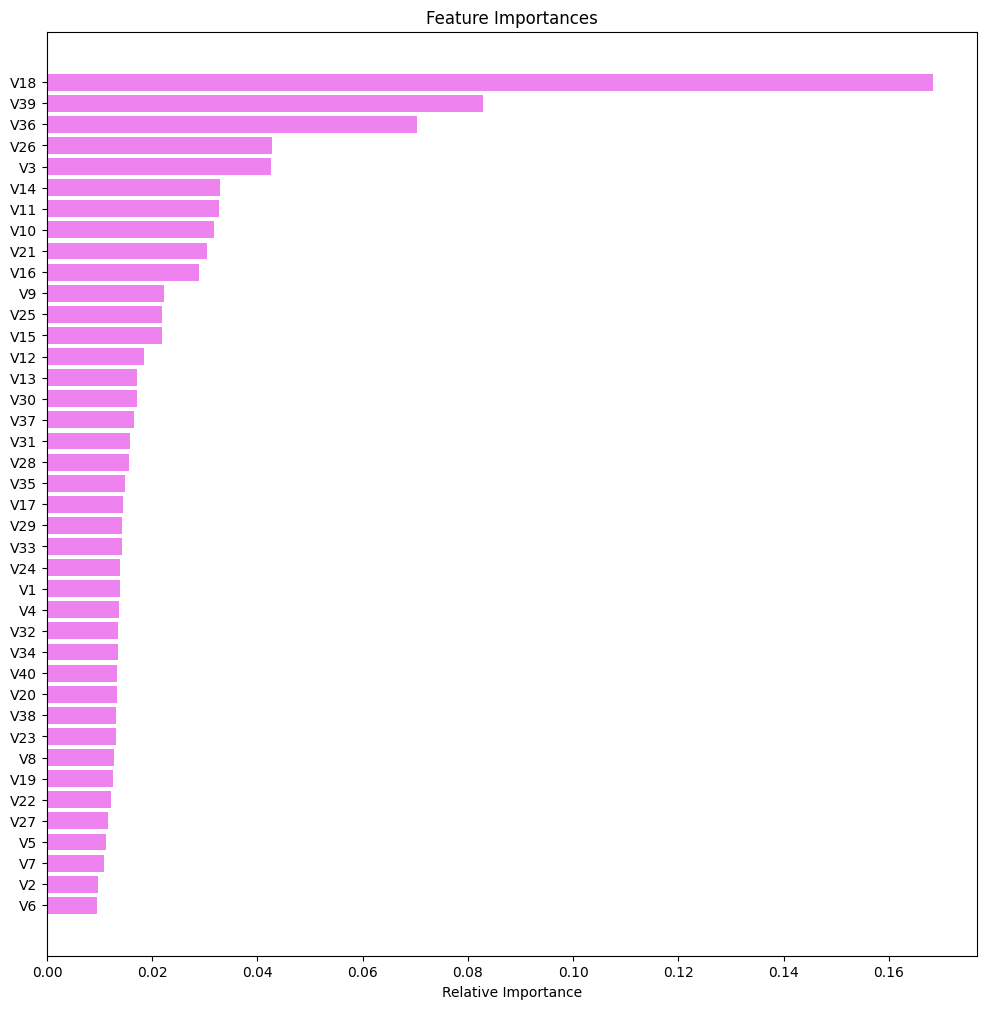

In [90]:
feature_names = data.columns
importances = final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- The top attributes which have the maximum importance for making accurate failure/ no-failure predictions are "V18", "V39", "V26", "V3" & "V10"

## Pipelines to build the final model

- Pipelines can be used to put the final model in production

In [91]:
# As we already know the final model, we will not be splitting train set into train and validation sets

X_train_pipeline = train.drop("Target", axis=1)
y_train_pipeline = train["Target"]

In [92]:
X_test_pipeline = test.drop("Target", axis=1)
y_test_pipeline = test["Target"]

In [95]:
model_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "XGB",
            XGBClassifier(
                subsample=0.9,
                scale_pos_weight=10,
                n_estimators=250,
                learning_rate=0.1,
                gamma=3,
                random_state=1,
                eval_metric="logloss",
            ),
        ),
    ]
)
# Fit the model on training data
model_pipeline.fit(X_train_pipeline, y_train_pipeline)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=250, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [96]:
# transforming and predicting on test data
model_pipeline.predict(X_test_pipeline)

array([0, 0, 0, ..., 0, 0, 0])

In [97]:
Minimum_Vs_Model_cost(y_test_pipeline, model_pipeline.predict(X_test_pipeline))

0.7797235023041474

- The pipeline performance is as expected (Minimum_Vs_Model_cost 0.779) indicating it was built accurately to replicate the final chosen model after necessary pre processing

# Business Insights and Conclusions

- A machine learning model has been built to minimize the total maintenance cost of machinery/processes used for wind energy production
    - The final tuned model (XGBoost) was chosen after building ~7 different machine learning algorithms & further optimizing for target class imbalance (having few "failures" and many "no failures" in dataset) as well as finetuning the algorithm performance (hyperparameter and cross validation techniques)

    - A pipeline was additionally built to productionise the final chosen model
   
   
- The model is expected to generalize well in terms of predictions & expected to result in a maintenance cost ~1.26 times minimum possible maintenance cost. Having no model in place for predictions could potentially result in costs as high as ~2.67 minimum possible maintenance cost. Hence, productionising the model has a large cost saving advantage

- The main attributes of importance for predicting failures vs. no failures were found to be "V18", "V39", "V26", "V3" & "V10" in order of decreasing importance. This added knowledge can be used to refine the process of collecting more frequent sensor information to be used in improving the machine learning model to further decrease maintenance costs